In [14]:
import numpy as np
from layers import *

In [15]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [16]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


In [17]:
# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

In [18]:
import json

# 1. JSON 데이터 로드 및 대화 내용 추출
def load_json_data(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # 대화 텍스트(utterance) 추출
    utterances = []
    for dialogue in data['data']:
        for utterance in dialogue['body']:
            utterances.append(utterance['utterance'])
    return utterances

# 2. 단어를 ID로 매핑 (Word-to-ID, ID-to-Word 생성)
def build_vocab(utterances):
    word_to_id = {}
    id_to_word = {}
    current_id = 0
    
    for sentence in utterances:
        words = sentence.split()  # 공백 기준으로 단어 분리
        for word in words:
            if word not in word_to_id:
                word_to_id[word] = current_id
                id_to_word[current_id] = word
                current_id += 1
    return word_to_id, id_to_word

# 3. 텍스트 데이터를 단어 ID로 변환하여 Corpus 생성
def create_corpus(utterances, word_to_id):
    corpus = []
    for sentence in utterances:
        words = sentence.split()
        corpus.extend([word_to_id[word] for word in words])
    return corpus

# 실행
filepath = 'dataset/sample.json'  # JSON 데이터 파일 경로
utterances = load_json_data(filepath)
word_to_id, id_to_word = build_vocab(utterances)
corpus = create_corpus(utterances, word_to_id)

# 4. 출력 및 사용
corpus_size = 1000  # 테스트 데이터 크기 설정
corpus = corpus[:corpus_size]  # corpus 크기 제한
vocab_size = len(word_to_id)

xs = corpus[:-1]  # 입력 데이터
ts = corpus[1:]   # 출력 데이터 (정답 레이블)

print(f"Corpus: {corpus[:10]}")  # 일부 확인
print(f"Vocab Size: {vocab_size}")
print(f"xs: {xs[:10]}")
print(f"ts: {ts[:10]}")

Corpus: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Vocab Size: 278403
xs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ts: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [19]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)

In [20]:
class SGD:
    '''
    確率的勾配降下法（Stochastic Gradient Descent）
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

In [21]:
def remove_duplicate(params, grads):
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [22]:
import matplotlib.pyplot as plt
import time

In [23]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


In [24]:
class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # バッチの各サンプルの読み込み開始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # パープレキシティの評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 278408.43
| epoch 2 |  iter 1 / 19 | time 8[s] | perplexity 276947.20
| epoch 3 |  iter 1 / 19 | time 17[s] | perplexity 269505.51
| epoch 4 |  iter 1 / 19 | time 25[s] | perplexity 258445.82
| epoch 5 |  iter 1 / 19 | time 33[s] | perplexity 243479.80
| epoch 6 |  iter 1 / 19 | time 42[s] | perplexity 222800.12
| epoch 7 |  iter 1 / 19 | time 51[s] | perplexity 191600.65
| epoch 8 |  iter 1 / 19 | time 59[s] | perplexity 160235.70
| epoch 9 |  iter 1 / 19 | time 67[s] | perplexity 132766.68
| epoch 10 |  iter 1 / 19 | time 76[s] | perplexity 104250.95
| epoch 11 |  iter 1 / 19 | time 86[s] | perplexity 84215.07
| epoch 12 |  iter 1 / 19 | time 94[s] | perplexity 69175.99
| epoch 13 |  iter 1 / 19 | time 102[s] | perplexity 55956.09
| epoch 14 |  iter 1 / 19 | time 111[s] | perplexity 45772.11
| epoch 15 |  iter 1 / 19 | time 120[s] | perplexity 38186.81
| epoch 16 |  iter 1 / 19 | time 129[s] | perplexity 31257.89
| epoch 17 |  iter 1 

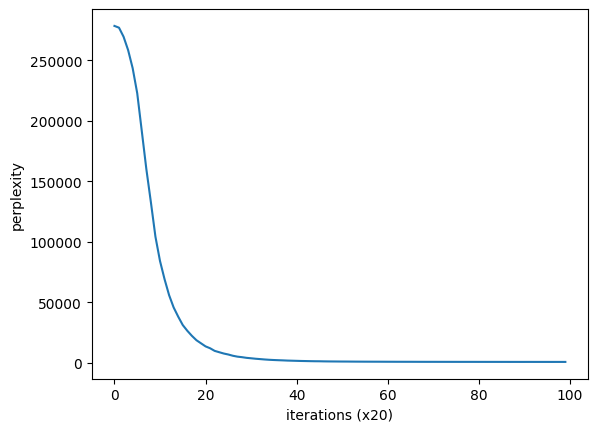

In [25]:
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()